In [362]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

Load Dataset

In [363]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Filter 1's and 0's

In [364]:
train_filter = np.where((train_labels == 0) | (train_labels == 1))
train_images = train_images[train_filter]
train_labels = train_labels[train_filter]

Flaten Images & Standardize Data

In [365]:
train_images_flat = train_images.reshape(train_images.shape[0], -1)

# handling NaN and Zero variance
if np.isnan(train_images_flat).any():
    train_images_flat = np.nan_to_num(train_images_flat, nan=0.0)

scaler = StandardScaler()
train_images_flat_std = scaler.fit_transform(train_images_flat)

Perform PCA

In [366]:
pca = PCA(n_components=2)
compressed_data = pca.fit_transform(train_images_flat_std)

Plot Data After PCA

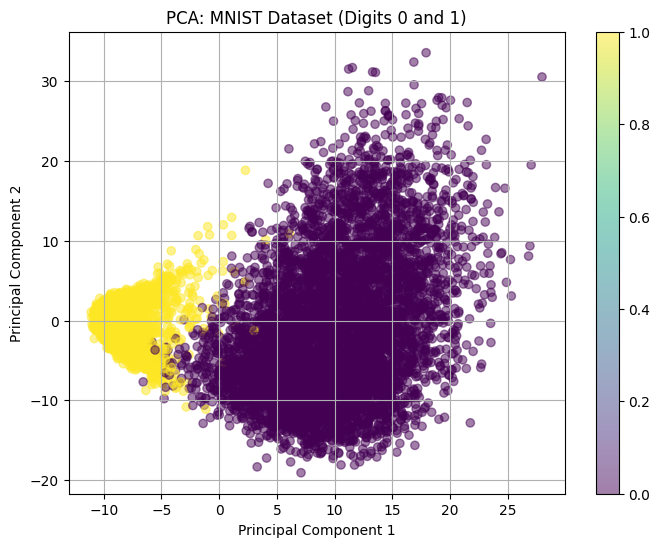

In [367]:
plt.figure(figsize=(8, 6))
plt.scatter(compressed_data[:, 0], compressed_data[:, 1], c=train_labels, cmap='viridis', alpha=0.5)
plt.title('PCA: MNIST Dataset (Digits 0 and 1)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.grid(True)
plt.show()

Fit GMM on PCA Data

Euclidean distance between the means: 18.21587605229954


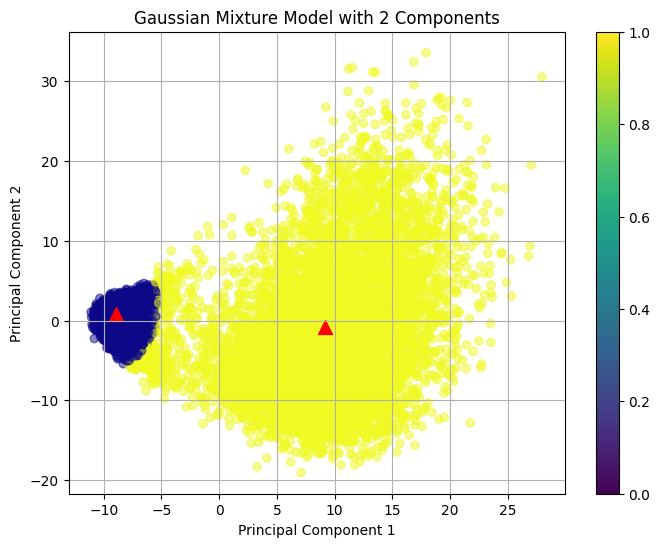

In [368]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(compressed_data)

means = gmm.means_
euclidean_distance = np.linalg.norm(means[0] - means[1])
print(f"Euclidean distance between the means: {euclidean_distance}")

labels = gmm.predict(compressed_data)

plt.figure(figsize=(8, 6))
plt.scatter(compressed_data[:, 0], compressed_data[:, 1], c=labels, cmap='plasma', alpha=0.5)
plt.scatter(means[:, 0], means[:, 1], c='red', marker='^', s=100, label='Gaussian Means')
plt.title('Gaussian Mixture Model with 2 Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.grid(True)
plt.show()

Reconstruct GMM Means and Display

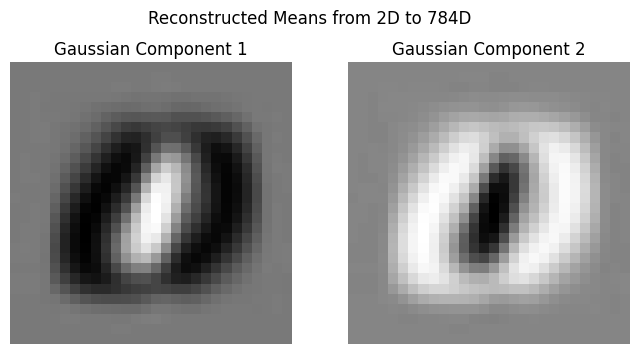

In [369]:
reconstructed_means = pca.inverse_transform(means)
reconstructed_images = reconstructed_means.reshape(-1, 28, 28)

plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.title(f'Gaussian Component {i+1}')
    plt.axis('off')
plt.suptitle('Reconstructed Means from 2D to 784D')
plt.show()

Analyze Samples with Nearly Equal Probabilities

Sample '9415' probability difference: 0.0013158248298417718
Sample '7565' probability difference: 0.0016392928567331988


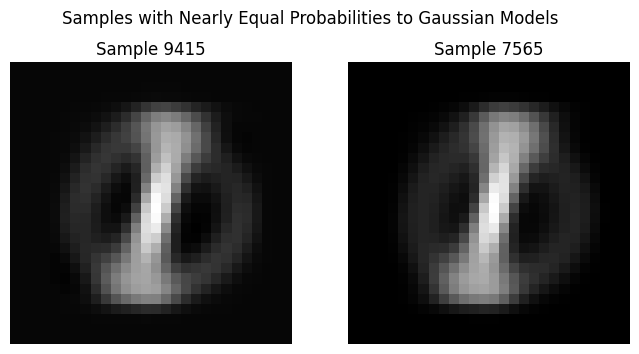

In [370]:
probabilities = gmm.predict_proba(compressed_data)

prob_diff = np.abs(probabilities[:, 0] - probabilities[:, 1])

min_diff_indices = np.argsort(prob_diff)[:2]

print(f"Sample '{min_diff_indices[0]}' probability difference:", prob_diff[min_diff_indices[0]])
print(f"Sample '{min_diff_indices[1]}' probability difference:", prob_diff[min_diff_indices[1]])

samples_near_equal_prob_2d = compressed_data[min_diff_indices]

# Inverse transform to reconstruct the samples back to 784-dimensional space
reconstructed_samples = pca.inverse_transform(samples_near_equal_prob_2d)

# Rescale the reconstructed samples back to the original data range
reconstructed_samples_rescaled = scaler.inverse_transform(reconstructed_samples)

samples_near_equal_prob_reshaped = reconstructed_samples_rescaled.reshape(-1, 28, 28)

plt.figure(figsize=(8, 4))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(samples_near_equal_prob_reshaped[i], cmap='gray')
    plt.title(f'Sample {min_diff_indices[i]}')
    plt.axis('off')
plt.suptitle('Samples with Nearly Equal Probabilities to Gaussian Models')
plt.show()

In [371]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

pair_differences = []

# Iterate through all pairs of dissimilar classes
for class1, class2 in combinations(range(10), 2):
    filter_mask = np.where((train_labels == class1) | (train_labels == class2))
    class_images = train_images[filter_mask]
    class_labels = train_labels[filter_mask]

    class_images_flat = class_images.reshape(class_images.shape[0], -1)

    if np.isnan(class_images_flat).any():
        class_images_flat = np.nan_to_num(class_images_flat, nan=0.0)

    scaler = StandardScaler()
    train_images_flat_std = scaler.fit_transform(class_images_flat)
    
    pca = PCA(n_components=2)
    compressed_data = pca.fit_transform(train_images_flat_std)
    
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(compressed_data)
    
    means = gmm.means_
    
    euclidean_distance = np.linalg.norm(means[0] - means[1])
    
    pair_differences.append(((class1, class2), euclidean_distance))

greatest_difference_pair = max(pair_differences, key=lambda x: x[1])
least_difference_pair = min(pair_differences, key=lambda x: x[1])

print(f"Pair with greatest difference between means: {greatest_difference_pair[0]} with distance {greatest_difference_pair[1]:.2f}")
print(f"Pair with least difference between means: {least_difference_pair[0]} with distance {least_difference_pair[1]:.2f}")

Pair with greatest difference between means: (0, 1) with distance 18.22
Pair with least difference between means: (2, 8) with distance 8.68


Plot Pair With the Least Difference

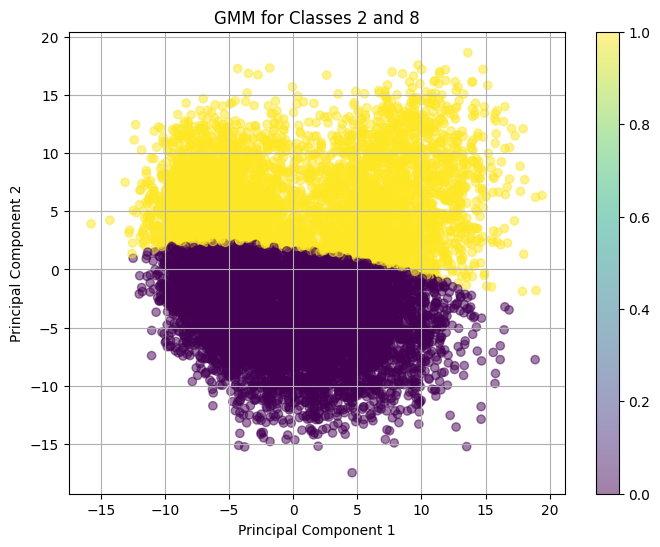

In [372]:
class1, class2 = least_difference_pair[0]
filter_mask = np.where((train_labels == class1) | (train_labels == class2))
class_images = train_images[filter_mask]
class_labels = train_labels[filter_mask]

class_images_flat = class_images.reshape(class_images.shape[0], -1)
scaler = StandardScaler()
class_images_flat_std = scaler.fit_transform(class_images_flat)
compressed_data = pca.fit_transform(class_images_flat_std)

gmm.fit(compressed_data)
labels = gmm.predict(compressed_data)

plt.figure(figsize=(8, 6))
plt.scatter(compressed_data[:, 0], compressed_data[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title(f'GMM for Classes {class1} and {class2}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.grid(True)
plt.show()